# Metadata

```
Course:   DS 5001
Module:   13 Lab
Topic:    Classification with a suite of SKLearn' linear classifiers
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'winereviews'

In [2]:
import pandas as pd
import numpy as np
import plotly_express as px
import importlib

# Get Data

In [3]:
DOCS = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_DOCS.csv").set_index(['doc_id'])
X_TRAIN = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TRAIN.csv").set_index(['doc_id'])
X_TEST = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TEST.csv").set_index(['doc_id'])
VOCAB = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_VOCAB.csv").set_index(['term_str'])

In [4]:
y_TRAIN = X_TRAIN.join(DOCS.doc_label).doc_label
y_TEST = X_TEST.join(DOCS.doc_label).doc_label

# Fit Models

In [5]:
models = {
    'LogisticRegression': {
        'slug': 'LR',
        'package': 'sklearn.linear_model',
        'args': {},
        'weights_cfg': {
            'data': 'coef_',
            'cols': 'feature_names_in_',
            'idx': None,
            'transpose': True
        }
    },
    'Perceptron': {
        'slug': 'PT',
        'package': 'sklearn.linear_model',
        'args': {},
        'weights_cfg': {
            'data': 'coef_',
            'cols': 'feature_names_in_',
            'idx': None,
            'transpose': True
        }
    },
    'BernoulliNB': {
        'slug': 'NB',
        'package': 'sklearn.naive_bayes',
        'args': {},
        'weights_cfg': {
            'data': 'feature_log_prob_',
            'cols': 'feature_names_in_',
            'idx': 'classes_',
            'transpose': True
        }
    },
    'LinearSVC': {
        'slug': 'SV',
        'package': 'sklearn.svm',
        'args': {},
        'weights_cfg': {
            'data': 'coef_',
            'cols': 'feature_names_in_',
            'idx': None,
            'transpose': True
        }
    }
}

In [6]:
def score_results(M):
    
    R = M.groupby('result_type').result_type.count().T
    
    # print(R)
    # print()

    # TP:  hits
    # FP:  Type I errors; false alarms
    # TN:  correct rejections
    # FN:  Type  II errors; misses
    # ACC: Accuracy
    # TPR: True Positive Rate, Recall, Sensitivity
    # TNR: True Negative Rate, Specificity
    # PPV: Positive Predictive Value, Precision
    # BA:  Balanced Accuracy
    # F1:  F-score where F = 1

    T = R.TP + R.TN
    F = R.FP + R.FN
    ALL =  T + F

    ACC = T / ALL
    TPR = R.TP / (R.TP + R.FN)
    TNR = R.TN / (R.TN + R.FP)
    PPV = R.TP / (R.TP + R.FP)
    BA = (TNR + TPR) / 2
    F1 = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN)

    assert ALL == R.sum()
    
    return {
        'TP' : R.TP,
        'TN' : R.TN,
        'FP' : R.FP,
        'FN' : R.FN,
        'TPR': round(TPR, 2),
        'TNR': round(TNR, 2),
        'F1' : round(F1,  2),
        'PPV': round(PPV, 2),
        'ACC': round(ACC, 2)
    }



In [7]:
def run_model(model_name):
    global models, X_TRAIN, X_TEST, y_TRAIN, y_TEST
    
    M = models[model_name]
    slug = M['slug']
    
    model_class = getattr(
        importlib.import_module(M['package']), 
        model_name
    )
    
    clf = model_class(**M['args'])
    clf.fit(X_TRAIN, y_TRAIN)
        
    M['score'] = clf.score(X_TRAIN, y_TRAIN)
    M['predictions'] = clf.predict(X_TEST)
    y_PREDICT = pd.Series(M['predictions'], index=X_TEST.index)
    
    RESULTS = pd.concat([y_TEST, y_PREDICT], axis=1, keys=['actual','prediction'])
    RESULTS['result'] = RESULTS.actual == RESULTS.prediction
    RESULTS['result_type'] = RESULTS.result.astype('str').str[0] + RESULTS.prediction
    M['results'] = RESULTS
    
    M['scores'] = score_results(RESULTS)
    
    # M['_object'] = clf
    
    df_data = getattr(clf, M['weights_cfg']['data'])
    # M['df_data'] = df_data
    
    if M['weights_cfg']['idx']:
        df_idx = getattr(clf, M['weights_cfg']['idx'])
    else:
        df_idx = [f'{slug}_weight']
        
    if M['weights_cfg']['cols']:
        df_cols = getattr(clf, M['weights_cfg']['cols'])
    else:
        df_cols = None

    try:
        M['weights'] = pd.DataFrame(df_data, index=df_idx, columns=df_cols)
        if M['weights_cfg']['transpose']:
            M['weights'] = M['weights'].T
        M['weights'].index.name = 'term_str'
    except ValueError as e:
        print(e)
        M['weights'] = None
    

In [8]:
for model_name in list(models.keys()):    
    print(model_name)
    run_model(model_name)

LogisticRegression
Perceptron
BernoulliNB
LinearSVC


# Group Weights

In [9]:
WEIGHTS = pd.concat([models[key]['weights'] for key in models.keys()], axis=1)

In [10]:
WEIGHTS

,LR_weight,PT_weight,N,P,SV_weight
term_str,,,,,
000,-0.451810,-4.0,-6.023888,-6.414114,-0.253937
04,0.075446,2.0,-7.728636,-6.724269,0.189470
05,-0.005089,0.0,-8.016318,-6.483107,0.000000
06,-0.494295,-7.0,-6.917706,-6.414114,-0.414115
07,0.257208,4.0,-7.728636,-6.819580,0.096972
...,...,...,...,...,...
zin,-1.047911,-5.0,-4.708211,-5.986670,-0.307168
zinfandel,-0.116510,-1.0,-4.615121,-5.408593,-0.109969
zing,0.043869,1.0,-7.169020,-6.924940,-0.110963


In [11]:
WEIGHTS['NB_weight'] = WEIGHTS.P - WEIGHTS.N
WEIGHTS = WEIGHTS.drop(['N','P'], axis=1)
WEIGHTS_NORMED = (WEIGHTS - WEIGHTS.mean()) / WEIGHTS.std()
WEIGHTS_MEAN = WEIGHTS_NORMED.mean(1).to_frame('weight')

In [12]:
WEIGHTS_MEAN

,weight
term_str,
000,-1.049431
04,0.046589
05,-0.129695
06,-1.166685
07,0.145903
...,...
zin,-1.592114
zinfandel,-0.708584
zing,-0.360642


# Compare Weights

In [13]:
WEIGHTS_NORMED = (WEIGHTS - WEIGHTS.mean()) / WEIGHTS.std()

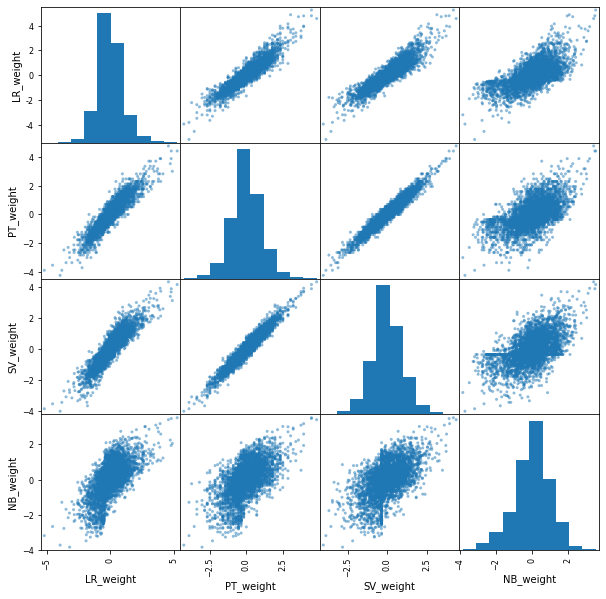

In [14]:
pd.plotting.scatter_matrix(WEIGHTS_NORMED, figsize=(10,10));

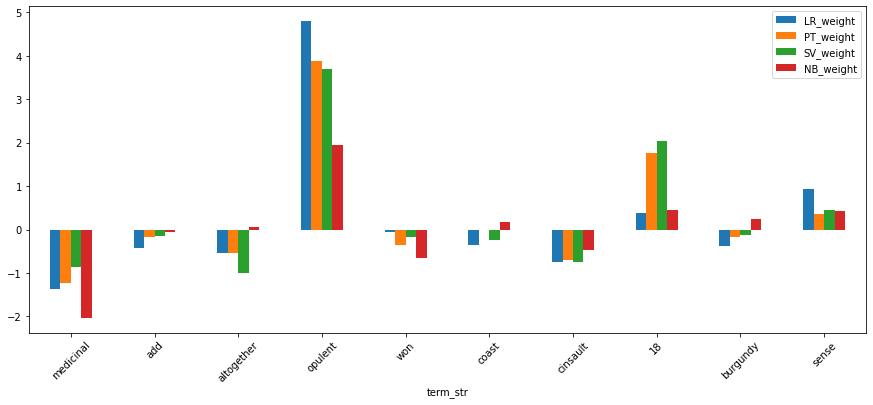

In [15]:
WEIGHTS_NORMED.sample(10).plot.bar(figsize=(15,6), rot=45);

# Get Top and Bottom Terms

In [16]:
tops = {}
bots = {}
for model_name in models.keys():
    slug = models[model_name]['slug']
    col = f"{slug}_weight"
    tops[slug] = WEIGHTS_NORMED.reset_index().sort_values(col, ascending=False).head(20).term_str.reset_index(drop=True)
    bots[slug] = WEIGHTS_NORMED.reset_index().sort_values(col, ascending=True).head(20).term_str.reset_index(drop=True)

tops['mean'] = WEIGHTS_MEAN.reset_index().sort_values('weight', ascending=False).head(20).term_str.reset_index(drop=True)
bots['mean'] = WEIGHTS_MEAN.reset_index().sort_values('weight', ascending=True).head(20).term_str.reset_index(drop=True)

TOPS = pd.concat(tops.values(), keys=tops.keys(), axis=1)
TOPS.index.name = 'rank'
BOTS = pd.concat(bots.values(), keys=tops.keys(), axis=1)
BOTS.index.name = 'rank'

In [17]:
TOPS

,LR,PT,NB,SV,mean
rank,,,,,
0,2022,2030,2022,2030,2022
1,beautiful,2025,2025,2022,2030
2,2025,2022,2030,2023,2025
3,opulent,opulent,2023,2025,2023
4,2020,wonderful,2024,wonderful,opulent
5,2030,2023,stunning,exceptional,wonderful
6,years,exceptional,decade,opulent,2024
7,wonderful,2024,gorgeous,2024,2020
8,delicious,loads,2021,loads,beautiful


In [18]:
BOTS

,LR,PT,NB,SV,mean
rank,,,,,
0,simple,easygoing,everyday,easygoing,simple
1,lacks,organic,easygoing,simple,easygoing
2,easygoing,simple,informal,pruney,lacks
3,organic,juiciness,dull,lacks,everyday
4,stalky,lacks,dilute,organic,organic
5,fairly,montepulciano,watery,diesel,fairly
6,easy,fairly,simple,characterizes,stalky
7,somewhat,isn,generic,montepulciano,montepulciano
8,everyday,characterizes,bland,excessive,isn


# Compare 

In [19]:
vals = []
idx = []
for model_name in models.keys():
    keys = models[model_name]['scores'].keys()
    idx.append(models[model_name]['slug']) 
    vals.append(models[model_name]['scores'].values())

In [20]:
pd.DataFrame(vals, columns=keys, index=idx).style.background_gradient(cmap='GnBu')

,TP,TN,FP,FN,TPR,TNR,F1,PPV,ACC
LR,2910,3007,89,120,0.960000,0.970000,0.970000,0.970000,0.970000
PT,2863,2982,114,167,0.940000,0.960000,0.950000,0.960000,0.950000
NB,2951,2929,167,79,0.970000,0.950000,0.960000,0.950000,0.960000
SV,2890,2967,129,140,0.950000,0.960000,0.960000,0.960000,0.960000


In [23]:
WEIGHTS

,LR_weight,PT_weight,SV_weight,NB_weight
term_str,,,,
000,-0.451810,-4.0,-0.253937,-0.390227
04,0.075446,2.0,0.189470,1.004366
05,-0.005089,0.0,0.000000,1.533211
06,-0.494295,-7.0,-0.414115,0.503591
07,0.257208,4.0,0.096972,0.909056
...,...,...,...,...
zin,-1.047911,-5.0,-0.307168,-1.278460
zinfandel,-0.116510,-1.0,-0.109969,-0.793472
zing,0.043869,1.0,-0.110963,0.244080
